# Business Understanding: 

**This notebook is dedicated to find an optimum solution for the MediaEval Video Memorability task. Our objective is to find the short-term and long-term memorability score for videos using semantic features like captions and video features like HMP and C3D.
This is done as part of Machine Learning assignment CA684. Our appraoch for this task will be to explore diffent features using multiple machine learning models and then improving the best model based on our results. Evaluation will be done using Spearman correlation coefficient.**

# Table of Contents

     1. Importing Dependencies
     2. Defining functions for some repetive tasks
     3. Exploring models with Semantic Captions
         3.1 RandomForest with 10 estimators
         3.2 RandomForest with 100 estimators
         3.3 SVR
         3.4 Baseline Network
     4. Exploring Captions with weights
         4.1 RandomForest with 10 estimators
         4.2 RandomForest with 100 estimators
         4.3 SVR
         4.4 Baseline Network
     5. HMP & Captions
         5.1 RandomForest with 10 estimators
         5.2 RandomForest with 100 estimators
         5.3 SVR
         5.4 Baseline Network
     6. C3D & Captions
         6.1 RandomForest with 10 estimators
         6.2 RandomForest with 100 estimators
         6.3 SVR
         6.4 Baseline Network
     7. Improving Best Model
         7.1 Cross Validation
         7.2 Time-based Learning Rate schedule and Decay
         7.3 Drop-based Learning Rate schedule
     8. Saving the model
     9. Creating Final submission
 

## 1. Importing Dependencies

In [175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

In [2]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
#from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gaurav\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
from sklearn.model_selection import train_test_split

In [4]:
from keras.models import Sequential
from keras.layers import Dense

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import cross_val_score
import numpy
from keras import regularizers
from keras import layers

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [5]:
# for reproducability
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

In [6]:
from keras.constraints import maxnorm
from keras.optimizers import SGD
from sklearn.model_selection import GridSearchCV

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
#from google.colab import drive
#drive.mount('/gdrive')
#%cd /gdrive

## 2. Defining functions for some repetive tasks

In [9]:
def Get_score(Y_pred,Y_true):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii],Y_true[:,ii])

In [10]:
def read_HMP(fname):
    """Scan HMP(Histogram of Motion Patterns) features from file"""
    with open(fname) as f:
        for line in f:
            pairs=line.split()
            HMP_temp = { int(p.split(':')[0]) : float(p.split(':')[1]) for p in pairs}
    # there are 6075 bins, fill zeros
    HMP = np.zeros(6075)
    for idx in HMP_temp.keys():
        HMP[idx-1] = HMP_temp[idx]            
    return HMP

In [11]:
def get_data():
    '''
      Get data for dev set
    '''
    train_ground_truth = pd.read_csv(r'CA684_Assignment\Dev-set\ground-truth.csv')
    train_ground_truth.drop(['nb_short-term_annotations', 'nb_long-term_annotations'], axis=1, inplace=True)
    train_captions = pd.read_csv('CA684_Assignment\Dev-set\dev-set_video-captions.txt',delimiter='\t',header= None,names=('video','Captions'))

    return train_ground_truth, train_captions


In [12]:
def clean_weigthed_corpus( df):
    '''
    Removes special characters, stopwords and create a bag of word model
    Assigns cumulative weights for certain words
    '''
    corpus = []
    weights = []
    for i in range(0, 6000):
        local_weight = 0
        caption = re.sub('[^a-zA-Z]', ' ', df['Captions'][i])
        caption = caption.lower()
        caption = caption.split()
        caption = [word for word in caption if not word in set(stopwords.words('english'))]
        for word in caption:
            if(word in set(weights_to_certain_words.keys())):
                    local_weight = local_weight + weights_to_certain_words[word]
        weights.append(local_weight)
        caption = ' '.join(caption)
        corpus.append(caption)

    return corpus, weights

In [13]:
def clean_corpus(df):
    '''
    Cleans the captions and create a bag of word model
    '''
    corpus = []
    for i in range(0, 6000):
        caption = re.sub('[^a-zA-Z]', ' ', df['Captions'][i])
        caption = caption.lower()
        caption = caption.split()
        caption = [word for word in caption if not word in set(stopwords.words('english'))]
        caption = ' '.join(caption)
        corpus.append(caption)
    return corpus

In [14]:
def baseline_model(n_col):
    '''
    Creating a sequential model for neural network
    '''
    model = Sequential()
    model.add(layers.Dropout(0.3, input_shape=(n_col,)))
    model.add(layers.Dense(10, activation='selu', kernel_regularizer=regularizers.l2(0.001),
                         kernel_initializer='he_normal'))
    model.add(layers.Dense(2, activation='sigmoid')) 
    model.compile(optimizer='adadelta', loss='mse', metrics=['accuracy']) 
 
    return model

In [53]:
def visualize(loss, val_loss):
    '''
    Plots a graph for training and validation loss and accuracy
    '''
    epochs = range(1,len(loss)+1)

    plt.figure()
    plt.plot(epochs,loss,'rv',label='Training loss')
    plt.plot(epochs,val_loss,'g',label='Validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

## 3. Exploring models with Semantic Captions:
Starting with Captions first as based on the previous work, captions have proven to be one the best features for this problem.
My approach will be to first clean the captions and then use tfidf vectorizer to create a feature vector which will be used as our training dataset. 

In [16]:
df,  captions_features= get_data()

In [17]:
df['video'] = df['video'].apply(lambda x : x.split('.')[0])

In [18]:
df.head()

,video,short-term_memorability,long-term_memorability
0,video3,0.924,0.846
1,video4,0.923,0.667
2,video6,0.863,0.700
3,video8,0.922,0.818
4,video10,0.950,0.900


In [19]:
captions_features['video'] = captions_features['video'].apply(lambda x : x.split('.')[0])
captions_features.head()

,video,Captions
0,video3,blonde-woman-is-massaged-tilt-down
1,video4,roulette-table-spinning-with-ball-in-closeup-shot
2,video6,khr-gangsters
3,video8,medical-helicopter-hovers-at-airport
4,video10,couple-relaxing-on-picnic-crane-shot


In [20]:
for line in df:
    df['Captions'] = captions_features['Captions']

In [21]:
corpus = clean_corpus(df)

In [22]:
len(corpus)

6000

In [23]:
tf_cap = TfidfVectorizer()

In [24]:
X = tf_cap.fit_transform(corpus).toarray()
Y = df.iloc[:, 1:3].values

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state=42)

**3.1 RandomForest with 10 estimators**

In [26]:
from sklearn.ensemble import RandomForestRegressor
cap_forest_regressor = RandomForestRegressor(n_estimators = 10, n_jobs = -1)
cap_forest_regressor.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [27]:
cap_predictions_rr1 = cap_forest_regressor.predict(X_test)
Get_score(cap_predictions_rr1, Y_test)

The Spearman's correlation coefficient is: 0.383
The Spearman's correlation coefficient is: 0.152


Random Forest with 10 estimators gives 0.383 spearman coefficient for short-term and 0.152 score for long-term.
* Short-term score = 0.383 
* Long-term score  = 0.152

**3.2 RandomForest with 100 estimators**

In [28]:
from sklearn.ensemble import RandomForestRegressor
cap_forest_regressor2 = RandomForestRegressor(n_estimators=100, n_jobs = -1)
cap_forest_regressor2.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [29]:
cap_predictions_rr2 = cap_forest_regressor2.predict(X_test)
Get_score(cap_predictions_rr2, Y_test)

The Spearman's correlation coefficient is: 0.413
The Spearman's correlation coefficient is: 0.149


For RandomForest with 100 estimators, we did considerably well for short-term score which is 0.413 but long-term is decreased. So there is a trade-off

* Short-term score = 0.413 
* Long-term score  = 0.149

**3.3 SVR FOR SHORT-TERM AND LONG-TERM MEMORABILITY**

In [30]:
from sklearn.svm import SVR

In [31]:
Y = df.iloc[:, 1:2].values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

In [32]:
cap_SVR_short = SVR().fit(X_train,Y_train.ravel())

In [33]:
cap_predictions_svr1 = cap_SVR_short.predict(X_test)
Get_score(cap_predictions_svr1, Y_test)

The Spearman's correlation coefficient is: 0.437


For Short-term we got 0.437 score which is better than random forest

In [34]:
Y = df.iloc[:, 2:3].values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

In [35]:
cap_SVR_long = SVR().fit(X_train,Y_train.ravel())

In [36]:
cap_predictions_svr2 = cap_SVR_long.predict(X_test)
Get_score(cap_predictions_svr2, Y_test)

The Spearman's correlation coefficient is: 0.189


For long-term also we got better results than random forest. So we can say that our SVR is performing better than random forest in case of captions
* Short-term score = 0.437 
* Long-term score  = 0.189

**3.4 Baseline MODEL with best parameters**

We will be using a neural network which has best prameters for this scenario, GridSearch was used to tune the parameters.

In [47]:
Y = df.iloc[:, 1:3].values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

In [48]:
n_col = X_train.shape[1]

In [49]:
cap_model_nn = baseline_model(n_col)
history = cap_model_nn.fit(X_train,Y_train, epochs=50, verbose=0, validation_data=(X_test,Y_test))

In [50]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

In [51]:
cap_predictions_nn = cap_model_nn.predict(X_test)
Get_score(cap_predictions_nn, Y_test)

The Spearman's correlation coefficient is: 0.443
The Spearman's correlation coefficient is: 0.204


The neural network is performing same as SVR for short-term memorability but has shown some improvement in long-term score. So overall performance for captions is best in case of neural network
* Short-term score = 0.443 
* Long-term score  = 0.204

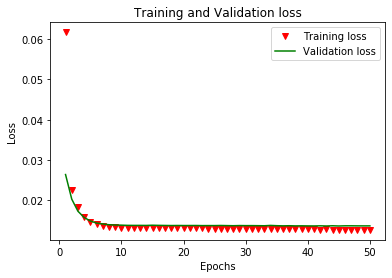

In [55]:
visualize(loss, val_loss)

## 4. Exploring Captions with weights
Referring to the previous work done in [this paper](http://ceur-ws.org/Vol-2283/MediaEval_18_paper_31.pdf), I will be assigning positive weights to certain words at the time of cleaning. These words seems to have extra effect in determing the score for videos.

In [56]:
df,captions_features= get_data()

In [57]:
df['video'] = df['video'].apply(lambda x : x.split('.')[0])
df.head()

,video,short-term_memorability,long-term_memorability
0,video3,0.924,0.846
1,video4,0.923,0.667
2,video6,0.863,0.700
3,video8,0.922,0.818
4,video10,0.950,0.900


In [58]:
captions_features['video'] = captions_features['video'].apply(lambda x : x.split('.')[0])
captions_features.head()

,video,Captions
0,video3,blonde-woman-is-massaged-tilt-down
1,video4,roulette-table-spinning-with-ball-in-closeup-shot
2,video6,khr-gangsters
3,video8,medical-helicopter-hovers-at-airport
4,video10,couple-relaxing-on-picnic-crane-shot


In [59]:
for line in df:
    df['Captions'] = captions_features['Captions']

In [60]:
weights_to_certain_words = {'women':16,'woman':16,'eating':15,'putting':14,'lying':13,'girl':12,'selfie':11,'relaxing':10,'jellyfish':9,'cat':8,'super':7,'slow':6,'super':5,'american':4,'potrait':3,'pregnant':2,'couple':1}

In [61]:
corpus, weights = clean_weigthed_corpus(df)

In [62]:
weights_df = pd.DataFrame(np.array(weights).reshape(6000,1))

In [63]:
tf = TfidfVectorizer()
captions_array = tf.fit_transform(corpus).toarray()
merged_array = np.concatenate((captions_array, weights_df), axis=1)

In [64]:
X = merged_array
Y = df.iloc[:, 1:3].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20,  random_state=42)

**4.1 RandomForest with 10 estimators**

In [65]:
wcap_forest_regressor1 = RandomForestRegressor(n_estimators = 10)
wcap_forest_regressor1.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [66]:
wcap_predictions_rr1 = wcap_forest_regressor1.predict(X_test)
Get_score(wcap_predictions_rr1, Y_test)

The Spearman's correlation coefficient is: 0.398
The Spearman's correlation coefficient is: 0.119


As expected captions with extra weights assigned has improved our model but thats seems to be the case for short-term memorability only. I might have gotten better results if I also included some negative weights too. 
* Short-term score = 0.398
* Long-term score  = 0.119

**4.2 RandomForest with 100 estimators**

In [67]:
cap_forest_regressor2 = RandomForestRegressor(n_estimators = 100, n_jobs = -1)
cap_forest_regressor2.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [68]:
wcap_predictions_rr2 = cap_forest_regressor2.predict(X_test)
Get_score(wcap_predictions_rr2, Y_test)

The Spearman's correlation coefficient is: 0.430
The Spearman's correlation coefficient is: 0.144


Random Forest with 100 estimators have shown significant improvement for weighted captions compared to when I was only using captions.

* Short-term score = 0.430 
* Long-term score  = 0.144

**4.3 SVR FOR Short-term and Long-term memorability**

In [69]:
Y = df.iloc[:, 1:2].values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

In [70]:
wcap_SVR_short = SVR(C=100).fit(X_train,Y_train.ravel())

In [71]:
wcap_predictions_svr1 = wcap_SVR_short.predict(X_test)
Get_score(wcap_predictions_svr1, Y_test)

The Spearman's correlation coefficient is: 0.392


In [72]:
Y = df.iloc[:, 2:3].values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

In [73]:
wcap_SVR_long = SVR(C=100).fit(X_train,Y_train.ravel())

In [74]:
wcap_predictions_svr2 = wcap_SVR_long.predict(X_test)
Get_score(wcap_predictions_svr2, Y_test)

The Spearman's correlation coefficient is: 0.183


We got some unexpected results, so far our performance was better for weighted captions but in case of SVR, the performance has decreased for short-term memorability.

* Short-term score = 0.392 
* Long-term score  = 0.183

**4.4 Baseline MODEL with best parameters**

In [75]:
Y = df.iloc[:, 1:3].values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

In [76]:
n_col = X_train.shape[1]

In [77]:
wcap_model_nn = baseline_model(n_col)
history = wcap_model_nn.fit(X_train,Y_train, epochs=30, verbose=0, validation_data=(X_test,Y_test))

In [78]:
wcap_predictions_nn = wcap_model_nn.predict(X_test)
Get_score(wcap_predictions_nn, Y_test)

The Spearman's correlation coefficient is: 0.401
The Spearman's correlation coefficient is: 0.198


Even the neural network with weighted captions did not improve the score of network with captions. I tried assigning diffent weights also but this is the best result for weighted captions using this network.

* Short-term score = 0.401 
* Long-term score  = 0.198

In [79]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

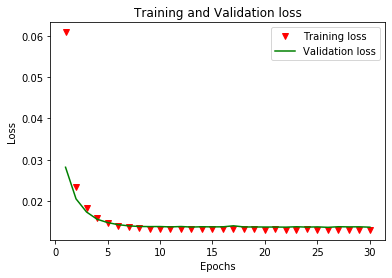

In [82]:
visualize(loss, val_loss)

## 5. HMP and Captions

Based on the previous work done on this challenge, Video features like HMP alone do not perform very well so I decided to combine them with Captions and explore the performance using various ml algorithms.

I also combined HMP with weighted captions while some models performed good compared to just combining HMP with normal captions but overall  the performance did not improved significantly.

In [83]:
df, captions_features = get_data()

In [84]:
df['video'] = df['video'].apply(lambda x : x.split('.')[0])
captions_features['video'] = captions_features['video'].apply(lambda x : x.split('.')[0])

In [85]:
for line in df:
    df['Captions'] = captions_features['Captions']

In [86]:
corpus = clean_corpus(df)

In [87]:
tf = TfidfVectorizer()

In [88]:
captions_array = tf.fit_transform(corpus).toarray()

In [89]:
os.getcwd() 

'C:\\Users\\Gaurav\\Desktop\\ML PROJECT'

In [90]:
NEW_PATH =r'C:\Users\Gaurav\Desktop\ML PROJECT\CA684_Assignment\Dev-set\HMP'

In [91]:
os.chdir(NEW_PATH)

In [92]:
os.getcwd() 

'C:\\Users\\Gaurav\\Desktop\\ML PROJECT\\CA684_Assignment\\Dev-set\\HMP'

In [93]:
HMP_feature_list= []
video_names_list = []

for filename in glob.glob('*.txt'):
    name = ((filename.split('/')[-1]).split('.')[0])
    video_names_list.append(name)
    HMP_features = read_HMP(filename)
    HMP_feature_list.append(HMP_features)

In [94]:
HMP_features = pd.DataFrame(np.array(HMP_feature_list).reshape(6000,6075))
HMP_features["video"] = video_names_list

In [95]:
pdf = pd.merge(df, HMP_features , on='video')

In [96]:
HMP_array = pdf.iloc[:,4:104].values

In [97]:
HMP_array.shape

(6000, 100)

In [98]:
merged_array = np.concatenate((captions_array, HMP_array), axis=1)

In [99]:
X = merged_array
Y = df.iloc[:, 1:3].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20,  random_state=42)

**5.1 RandomForest with 10 estimators**

In [100]:
chmp_forest_regressor1 = RandomForestRegressor(n_estimators = 10, n_jobs=-1)
chmp_forest_regressor1.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [101]:
chmp_predictions_rr1 = chmp_forest_regressor1.predict(X_test)
Get_score(chmp_predictions_rr1, Y_test)

The Spearman's correlation coefficient is: 0.246
The Spearman's correlation coefficient is: 0.099


As expected video features did not improve the performance very well either.
* Short-term Score is 0.246
* Long-term Score is 0.099

**5.2 RandomForest with 100 estimators**

In [102]:
chmp_forest_regressor2 = RandomForestRegressor(n_estimators = 100, n_jobs=-1)
chmp_forest_regressor2.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [103]:
chmp_predictions_rr2 = chmp_forest_regressor2.predict(X_test)
Get_score(chmp_predictions_rr2, Y_test)

The Spearman's correlation coefficient is: 0.327
The Spearman's correlation coefficient is: 0.119


Although 100 estimators did show some improvement but overall the performance has decreased after including the HMP features.
* Short-term score = 0.327
* Long-term score  = 0.119

**5.3 SVR FOR Short-term and Long-term memorability**

In [104]:
Y = df.iloc[:, 1:2].values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

In [105]:
chmp_SVR_short = SVR(C=100).fit(X_train,Y_train.ravel())

In [106]:
chmp_predictions_svr1 = chmp_SVR_short.predict(X_test)
Get_score(chmp_predictions_svr1, Y_test)

The Spearman's correlation coefficient is: 0.416


In [107]:
Y = df.iloc[:, 2:3].values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

In [108]:
chmp_SVR_long = SVR(C=100).fit(X_train,Y_train.ravel())

In [109]:
chmp_predictions_svr2 = chmp_SVR_long.predict(X_test)
Get_score(chmp_predictions_svr2, Y_test)

The Spearman's correlation coefficient is: 0.182


SVR model did performed better that weighted captions model in case of short-term memorability.
* Short-term score = 0.416
* Long-term score = 0.182

**5.4 Baseline MODEL with best parameters**

In [110]:
Y = df.iloc[:, 1:3].values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=1)

In [111]:
n_col = X_train.shape[1]

In [114]:
chmp_model_nn = baseline_model(n_col)
history = chmp_model_nn.fit(X_train,Y_train, epochs=50, verbose=0, validation_data=(X_test,Y_test))

In [115]:
chmp_predictions_nn = chmp_model_nn.predict(X_test)
Get_score(chmp_predictions_nn, Y_test)

The Spearman's correlation coefficient is: 0.407
The Spearman's correlation coefficient is: 0.230


We got better results for long-term score but the short-term score is not as good as we got for captions only.
* Short-term score = 0.407
* Long-term score = 0.230

In [116]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

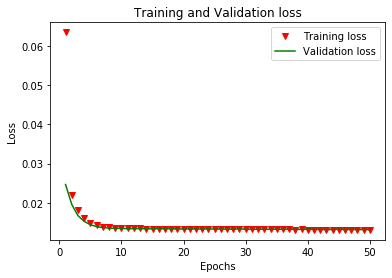

In [117]:
visualize(loss, val_loss)

## 6. C3D and Captions
My approach for C3D features will be same as it was for HMP features. 

In [118]:
NEW_PATH =r'C:\Users\Gaurav\Desktop\ML PROJECT'

In [119]:
os.chdir(NEW_PATH)

In [120]:
df, captions_features = get_data()

In [121]:
df['video'] = df['video'].apply(lambda x : x.split('.')[0])
captions_features['video'] = captions_features['video'].apply(lambda x : x.split('.')[0])

In [122]:
for line in df:
    df['Captions'] = captions_features['Captions']

In [123]:
corpus = clean_corpus(df)

In [124]:
tf = TfidfVectorizer()

In [125]:
captions_array = tf.fit_transform(corpus).toarray()

In [126]:
NEW_PATH =r'C:\Users\Gaurav\Desktop\ML PROJECT\CA684_Assignment\Dev-set\C3D'

In [127]:
os.chdir(NEW_PATH)

In [128]:
C3D_feature_list= []
video_names_list = []

for filename in glob.glob('*.txt'):
    name = ((filename.split('/')[-1]).split('.')[0])
    video_names_list.append(name) 
    with open(filename) as f:
        for line in f:
            C3D_features =[float(item) for item in line.split()]
    C3D_feature_list.append(C3D_features)

In [129]:
C3D_features = pd.DataFrame(np.array(C3D_feature_list).reshape(6000,101))
C3D_features["video"] = video_names_list

In [130]:
pdf = pd.merge(df, C3D_features , on='video')

In [131]:
C3D_array = pdf.iloc[:,4:104].values

In [132]:
C3D_array.shape

(6000, 100)

In [133]:
merged_array = np.concatenate((captions_array, C3D_array), axis=1)

In [134]:
X = merged_array
Y = df.iloc[:, 1:3].values

In [135]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20,  random_state=42)

**6.1 RandomForest with 10 estimators**

In [136]:
cc3d_forest_regressor1 = RandomForestRegressor(n_estimators = 10, n_jobs=-1)
cc3d_forest_regressor1.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [137]:
cc3d_predictions_rr1 = cc3d_forest_regressor1.predict(X_test)
Get_score(cc3d_predictions_rr1, Y_test)

The Spearman's correlation coefficient is: 0.256
The Spearman's correlation coefficient is: 0.088


With 10 estimators the performance is even lower than what we got for HMP&Captions combination.
* Short-term score = 0.256 
* Long-term score  = 0.088

**6.2 RandomForest with 100 estimators**

In [138]:
cc3d_forest_regressor2 = RandomForestRegressor(n_estimators = 100, n_jobs=-1)
cc3d_forest_regressor2.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [139]:
cc3d_predictions_rr2 = cc3d_forest_regressor2.predict(X_test)
Get_score(cc3d_predictions_rr2, Y_test)

The Spearman's correlation coefficient is: 0.333
The Spearman's correlation coefficient is: 0.101


But as we increased the estimators the results improved compared to the HMP combination.
* Short-term score = 0.333 
* Long-term score  = 0.101

**6.3 SVR FOR Short-term and Long-term memorability**

In [140]:
Y = df.iloc[:, 1:2].values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

In [141]:
cc3d_SVR_short = SVR(C=100).fit(X_train,Y_train.ravel())

In [142]:
cc3d_predictions_svr1 = cc3d_SVR_short.predict(X_test)
Get_score(cc3d_predictions_svr1, Y_test)

The Spearman's correlation coefficient is: 0.409


In [143]:
Y = df.iloc[:, 2:3].values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state= 42)

In [144]:
cc3d_SVR_long = SVR(C=100).fit(X_train,Y_train.ravel())

In [145]:
cc3d_predictions_svr2 = cc3d_SVR_long.predict(X_test)
Get_score(cc3d_predictions_svr2, Y_test)

The Spearman's correlation coefficient is: 0.155


Not much change observed scores seems almost same as to the HMP combination.
* Short-term score = 0.409 
* Long-term score  = 0.155

**6.4 Baseline MODEL with best parameters**

In [146]:
Y = df.iloc[:, 1:3].values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

In [147]:
n_col = X_train.shape[1]

In [148]:
cc3d_model_nn = baseline_model(n_col)
history = cc3d_model_nn.fit(X_train,Y_train, epochs=30, verbose=0, validation_data=(X_test,Y_test))

In [149]:
cc3d_predictions_nn = cc3d_model_nn.predict(X_test)
Get_score(cc3d_predictions_nn, Y_test)

The Spearman's correlation coefficient is: 0.408
The Spearman's correlation coefficient is: 0.194


Out of all models for this combination, sequential model gives the best results. It is almost as same as the result we got from captions. But this just proves that even after adding extra features we were not able to improve our model significantly.

* Short-term score = 0.408 
* Long-term score  = 0.194

In [150]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

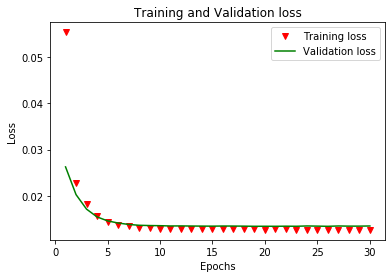

In [151]:
visualize(loss, val_loss)

## 7. Improving Best Model

The best model so far is the network we created using captions only with **Short-term Score: 0.438 and Long-term Score: 0.208**. So we will further try to improve this model using advanced techniques. Although we were using the best parameters for the model with help of GridSearchCV, now our approach will be to modify learning rate by different techniques.

In [152]:
NEW_PATH =r'C:\Users\Gaurav\Desktop\ML PROJECT'

In [153]:
os.chdir(NEW_PATH)

In [154]:
df,  captions_features= get_data()

In [155]:
df['video'] = df['video'].apply(lambda x : x.split('.')[0])

In [156]:
captions_features['video'] = captions_features['video'].apply(lambda x : x.split('.')[0])

In [157]:
for line in df:
    df['Captions'] = captions_features['Captions']

In [158]:
corpus = clean_corpus(df)

In [159]:
tf = TfidfVectorizer()

In [160]:
X = tf.fit_transform(corpus).toarray()
Y = df.iloc[:, 1:3].values

In [161]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state=42)

In [162]:
n_col = X_train.shape[1]

**7.1 Cross Validation**

I took reference for this topic from [this article](https://machinelearningmastery.com/k-fold-cross-validation/). Using Cross Validation: 
* 1. we build K different models, so we are able to make predictions on all of our data. 
* 2. we are able to get more metrics and draw important conclusion both about our algorithm and our data.

cross_val_score calls the .score() method of the estimator you pass in and what that returns varies depending on the estimator, in our case we get MSE.

In [163]:
def b_model():
    model = Sequential()
    model.add(layers.Dropout(0.3, input_shape=(n_col,)))
    model.add(layers.Dense(10, activation='selu', kernel_regularizer=regularizers.l2(0.001),
                       kernel_initializer='he_normal'))
    model.add(layers.Dense(2, activation='sigmoid')) 
    model.compile(optimizer='adadelta', loss='mse', metrics=['accuracy']) 
 
    return model

In [164]:
# INstead of fit() we use keras model 
model = KerasRegressor(build_fn=b_model, epochs=100, batch_size=10, verbose=0)

# evaluate using 5-fold cross validation
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [165]:
cross_val_score(model, X_train, Y_train, cv=kfold, verbose=10, n_jobs = -1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.0min remaining:  6.0min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  4.0min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.0min finished


array([-0.01248829, -0.01314588, -0.01372077, -0.01283476, -0.01338728])

The MSE is between 0.0124 to 0.0139, so the difference is insignificant. Hence we can fit our model in a homogenous manner on the dataset.

**7.2 Learning Curve**

In [166]:
from sklearn.model_selection import learning_curve

def randomize(X, Y):
    permutation = np.random.permutation(Y.shape[0])
    X2 = X[permutation,:]
    Y2 = Y[permutation]
    return X2, Y2


def draw_learning_curves(X, Y, estimator, num_trainings):
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, 
                                                            X, Y, cv=None, n_jobs=-1, 
                                                            train_sizes=np.linspace(0.1, 1.0, 
                                                                                    num_trainings))

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.grid()

    plt.title("Learning Curves")
    plt.xlabel("Training instances")
    plt.ylabel("Score")

    plt.plot(train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


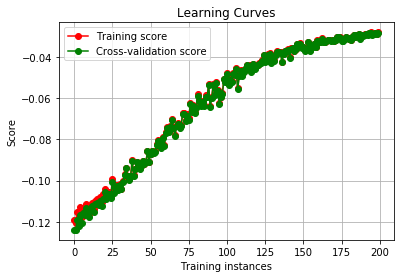

In [167]:
model = KerasRegressor(build_fn=b_model, verbose=10)

X_LC, Y_LC = randomize(X_train, Y_train) 

draw_learning_curves(X_LC, Y_LC, estimator=model, num_trainings=200)

**7.3 Time-based Learning Rate schedule and Decay**

Reference for this appraoch is taken from [this article in towards data science](https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/).
Keras has a time-based learning rate schedule built in. And in this approach we will be decreasing the learning rate gradually based on the epoch. The decay argument is used in equation as follows:

```LearningRate = LearningRate * 1/(1 + decay * epoch)```

In [184]:
model = Sequential()
model.add(layers.Dropout(0.3, input_shape=(n_col,)))
model.add(layers.Dense(10, activation='selu', kernel_regularizer=regularizers.l2(0.001),
                       kernel_initializer='he_normal',  kernel_constraint = maxnorm(5)))
model.add(layers.Dense(2, activation='sigmoid')) 

In [185]:
epochs = 50
lr = 0.1
momentum = 0.9
decay_rate = lr / epochs
sgd = SGD(lr=lr, momentum=momentum, decay=decay_rate, nesterov=False)


In [186]:
model.compile(optimizer=sgd, loss='mse', metrics=['accuracy'])

In [187]:
model.fit(X_train, Y_train, epochs=epochs, verbose=0, validation_data=(X_test,Y_test))

In [188]:
predictions = model.predict(X_test) 

In [189]:
Get_score(predictions, Y_test)

The Spearman's correlation coefficient is: 0.427
The Spearman's correlation coefficient is: 0.195


**7.4 Drop-based Learning Rate schedule**

In this approach we will be decreasing the learning rate using punctuated large drops at specific epochs. We will be  implementing this by dropping the learning rate by half every fixed number of epochs. For example, we may have an initial learning rate of 0.1 and drop it by 0.5 every 10 epochs. The first 10 epochs of training would use a value of 0.1, in the next 10 epochs a learning rate of 0.05 would be used, and so on.

A new step_decay() function is defined that implements the equation:

```LearningRate = InitialLearningRate * DropRate^floor(Epoch / EpochDrop)``` [Reference](https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/)

In [176]:
import math
from keras.callbacks import LearningRateScheduler


'''
LearningRate = LearningRate(0) * DropRate to the power: floor{(1 + epoch)/epoch_drop} 
'''

#Epoch_Drop is how often the learning rate is dropped in epochs and 
#DropRate is how much to drop the learning rate each time it is dropped

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.3
    epochs_drop = 15.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
 #   print (‘epoch: ‘ + str(epoch) + ‘, learning rate: ‘ + str(lrate))
    return lrate

In [177]:
model = Sequential()
model.add(layers.Dropout(0.3, input_shape=(n_col,)))
model.add(layers.Dense(10, activation='selu', kernel_regularizer=regularizers.l2(0.001),
                       kernel_initializer='he_normal',  kernel_constraint = maxnorm(5)))
model.add(layers.Dense(2, activation='sigmoid')) 

In [178]:
# Compile model
sgd = SGD(lr=0.0, momentum=0.9, decay=0.0, nesterov=False)

In [179]:
model.compile(loss='mse', optimizer=sgd, metrics=['accuracy'])

In [180]:
# Fit the model
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]

In [181]:
model.fit(X_train, Y_train, epochs=100, callbacks = callbacks_list, verbose=0, 
            validation_data=(X_test,Y_test))

In [182]:
predictions = model.predict(X_test) 

In [183]:
Get_score(predictions, Y_test)

The Spearman's correlation coefficient is: 0.434
The Spearman's correlation coefficient is: 0.200


Out of the two techniques we got best results using "Drop-based Learning Rate schedule". So we will predict our final submission using this model.

## 8. Saving the model

In [163]:
model.save('./final_model.h5')  # creates a HDF5 file 'my_model.h5'

## 9. Creating final submission

We will re-train our model by using full dev-set data and then use transform() to create X_test dataset which will be used to generate final predictions. We are using transform() instead of fit_transform() for tfidfvectorizer() because we don't want to change the shape of our X_test.

In [164]:
df,  captions_features= get_data()
df['video'] = df['video'].apply(lambda x : x.split('.')[0])
captions_features['video'] = captions_features['video'].apply(lambda x : x.split('.')[0])
for line in df:
    df['Captions'] = captions_features['Captions']
corpus = clean_corpus(df)

tf_cap = TfidfVectorizer()

X = tf_cap.fit_transform(corpus).toarray()
Y = df.iloc[:, 1:3].values

n_col = X_train.shape[1]

In [165]:
model.fit(X, Y, epochs=100)

Epoch 1/100
6000/6000 [==============================] - 1s 130us/step - loss: 0.0134 - accuracy: 0.7048
Epoch 2/100
6000/6000 [==============================] - 1s 124us/step - loss: 0.0134 - accuracy: 0.7048
Epoch 3/100
6000/6000 [==============================] - 1s 126us/step - loss: 0.0134 - accuracy: 0.7048
Epoch 4/100
6000/6000 [==============================] - 1s 120us/step - loss: 0.0134 - accuracy: 0.7048
Epoch 5/100
6000/6000 [==============================] - 1s 122us/step - loss: 0.0134 - accuracy: 0.7048
Epoch 6/100
6000/6000 [==============================] - 1s 122us/step - loss: 0.0134 - accuracy: 0.7048
Epoch 7/100
6000/6000 [==============================] - 1s 122us/step - loss: 0.0134 - accuracy: 0.7048
Epoch 8/100
6000/6000 [==============================] - 1s 122us/step - loss: 0.0134 - accuracy: 0.7048
Epoch 9/100
6000/6000 [==============================] - 1s 123us/step - loss: 0.0134 - accuracy: 0.7048
Epoch 10/100
6000/6000 [==============================]

In [166]:
test_captions = pd.read_csv('test-set-1_video-captions.txt',delimiter='\t',header= None,names=('video','Captions'))

In [167]:
test_captions['video'] = test_captions['video'].apply(lambda x : x.split('.')[0])

In [168]:
corpus = []
for i in range(0, 2000):
    caption = re.sub('[^a-zA-Z]', ' ', test_captions['Captions'][i])
    caption = caption.lower()
    caption = caption.split()
    caption = [word for word in caption if not word in set(stopwords.words('english'))]
    caption = ' '.join(caption)
    corpus.append(caption)

In [169]:
X = tf_cap.transform(corpus).toarray()
Y = df.iloc[:, 1:3].values

In [170]:
predictions = model.predict(X)

In [171]:
predictions.shape

(2000, 2)

In [172]:
final_submission = pd.read_csv('ground_truth_template.csv')

In [173]:
final_submission.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,7494,NaN,33,NaN,12
1,7495,NaN,34,NaN,10
2,7496,NaN,32,NaN,13
3,7497,NaN,33,NaN,10
4,7498,NaN,33,NaN,10


In [174]:
final_submission['short-term_memorability'] = predictions[:, :1]
final_submission['long-term_memorability'] = predictions[:, 1:]

In [175]:
final_submission.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,7494,0.856241,33,0.766113,12
1,7495,0.855958,34,0.774394,10
2,7496,0.863338,32,0.787460,13
3,7497,0.860252,33,0.778751,10
4,7498,0.857380,33,0.766862,10


In [179]:
final_submission.shape

(2000, 5)

In [180]:
final_submission.tail()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
1995,10004,0.859034,34,0.778440,17
1996,10005,0.861394,34,0.782710,9
1997,10006,0.863306,34,0.781532,12
1998,10007,0.862973,34,0.789883,12
1999,10008,0.866506,33,0.792543,10


In [181]:
final_submission.to_csv('final_submission.csv')